In [1]:
from keras.datasets import mnist, cifar100
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import (
    UpSampling2D,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    AveragePooling2D,
)
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
import keras
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

import shutil, os, sys, io, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensor_board_logger import TensorBoardLogger
from layer_visualizer import LayerVisualizer
from tqdm import tqdm

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

In [2]:
class GAN:
    def __init__(self):
        # ---------------------
        #  for log on TensorBoard
        # ---------------------
        target_dir = "./my_log_dir2"
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)

        # ---------------------
        #  Parameter
        # ---------------------
        self.unrolling_steps = 0
        self.multiple = 1
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows * self.multiple, self.img_cols* self.multiple, self.channels)
        self.input_rows = int(self.img_rows * self.multiple / 16)
        self.input_cols = int(self.img_cols * self.multiple / 16)
        self.latent_dim = 100  # Noiseの次元
        optimizer = Adam(lr=0.0002, beta_1=0.5) #
        # optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

        # ---------------------
        #  Build and compile the discriminator
        # ---------------------
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = True
        self.discriminator.compile(
            loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
        )

        # ---------------------
        #  Build and compile the combined model
        # ---------------------
        # Build the generator
        self.generator = self.build_generator()

        # Instantiate the combined model
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        validity = self.discriminator(img)
        self.combined = Model(z, validity)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Compile the combined model
        self.combined.compile(
            loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
        )

    def build_generator(self):
        model = Sequential()
        model.add(Dense(self.input_rows * self.input_cols * 1024, activation="relu", input_dim=self.latent_dim,
                       kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None),
                       ))
        model.add(Reshape((self.input_rows, self.input_cols, 1024)))
        
        model.add(Conv2DTranspose(512, (5, 5), strides=2, padding='same', 
                                 kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None),
                                 ))
        model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU(max_value=None))
        
        model.add(Conv2DTranspose(256, (5, 5), strides=2, padding='same', 
                                 kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None),
                                 ))
        model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU(max_value=None))

        model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same', 
                                 kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None),
                                 ))
        model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU(max_value=None))
        
        model.add(Conv2DTranspose(3, (5, 5), strides=2, padding='same', 
                                 kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None),
                                 ))                             
        model.add(Activation("tanh"))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(64, (5, 5), strides=2, input_shape=self.img_shape, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, (5, 5), strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, (5, 5), strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(512, (5, 5), strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation="sigmoid"))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        # ---------------------
        #  Load the dataset
        # ---------------------
        # mnist      
        # (X_train, _), (_, _) = mnist.load_data()
        # X_train = X_train / 127.5 - 1.0   # Rescale -1 to 1
        
        # cifar100           
        # (X_train, y_train), (_, _) = cifar100.load_data(label_mode='fine')
        # X_train = X_train[y_train.flatten() == 8]
        # X_train = X_train / 127.5 - 1.0   # Rescale -1 to 1
        
        # LFW: The Labeled Faces in the Wild    
        # lfw_people = fetch_lfw_people()
        # X_train = lfw_people.images
        # X_train = X_train / 127.5 - 1.0   # Rescale -1 to 1

        # Load the Olivetti faces data-set from AT&T
        # olivetti_people = fetch_olivetti_faces()
        # X_train = olivetti_people.images
        
        # Original dataset
        X_train = np.load('datasets/lfw.npy')
        X_train = X_train / 127.5 - 1.0   # Rescale -1 to 1
        
        if self.multiple != 1:
            X_train = X_train.repeat(self.multiple, axis=1).repeat(self.multiple, axis=2)

        if self.channels == 1:
            X_train = np.expand_dims(X_train, axis=3)  # Insert a new axis.

        # Adversarial ground truths
        valid_1 = np.ones((batch_size, 1))
        fake_0 = np.zeros((batch_size, 1))
        valid = (1.2 - 0.7) * np.random.rand(batch_size, 1) + 0.7
        fake = (0.3 - 0.0) * np.random.rand(batch_size, 1) + 0.0

        for epoch in tqdm(range(epochs + 1)):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Generate a batch of new images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(
                imgs, valid
            )  # 単一バッチデータにつき一度の勾配更新を行う。
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Unrolling Process 1 (Train discriminator unrolling_step times)
            # ---------------------
            if self.unrolling_steps != 0:
                # Backup weights
                backup_weights = self.discriminator.get_weights()

                # Unrolling
                for _ in range(self.unrolling_steps):
                    # Generate a batch of new images
                    idx = np.random.randint(0, X_train.shape[0], batch_size)
                    imgs = X_train[idx]

                    # Generate a batch of new images
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    gen_imgs = self.generator.predict(noise)

                    # Train the discriminator
                    d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                    d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid_1)

            # ---------------------
            #  Unrolling Process 2 (Unbdo weights)
            # ---------------------
            if self.unrolling_steps != 0:
                # Undo waights
                self.discriminator.set_weights(backup_weights)

            # ---------------------
            #  Log on TensorBoard
            # ---------------------
            logs = {
                "Discriminator/loss": d_loss[0],
                "Generator/loss": g_loss[0],
                "Generator/acc": g_loss[1],
            }
            histograms = {}
            for layer in self.generator.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if "conv" in layer.name or "dense" in layer.name:
                        name = layer.name + "/" + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch)

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                fig, name = self.sample_images(epoch)
                images = {name: fig}
                self.logger.log(images=images, epoch=epoch)
                print(
                    "%d [D loss: %f] [G loss: %f, G acc.: %.2f%%]"
                    % (epoch, d_loss[0], g_loss[0], 100 * g_loss[1])
                )

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                if self.channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap="gray")
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :self.channels], cmap="gray")
                axs[i, j].axis("off")
                cnt += 1
        name = str(epoch) + ".png"
        return fig, name
        # fig.savefig("images/%d.png" % epoch)
        # plt.close()

In [3]:
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
__________

  0%|          | 0/10001 [00:00<?, ?it/s]/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 1/10001 [00:21<59:09:43, 21.30s/it]

0 [D loss: 2.506965] [G loss: 1.798763, G acc.: 7.03%]


 10%|█         | 1001/10001 [23:37<3:53:49,  1.56s/it]

1000 [D loss: 0.661125] [G loss: 2.178320, G acc.: 2.34%]


 20%|██        | 2001/10001 [46:44<3:12:01,  1.44s/it]

2000 [D loss: 0.422027] [G loss: 2.182240, G acc.: 0.78%]


 30%|███       | 3001/10001 [1:09:52<2:48:44,  1.45s/it]

3000 [D loss: 0.465002] [G loss: 1.718487, G acc.: 9.38%]


 40%|████      | 4001/10001 [1:33:22<2:24:03,  1.44s/it]

4000 [D loss: 0.602621] [G loss: 2.107563, G acc.: 1.56%]


 50%|█████     | 5001/10001 [1:56:34<2:07:39,  1.53s/it]

5000 [D loss: 0.457751] [G loss: 1.607226, G acc.: 10.16%]


 60%|██████    | 6001/10001 [2:19:46<1:46:54,  1.60s/it]

6000 [D loss: 0.486128] [G loss: 1.119244, G acc.: 28.12%]


 70%|███████   | 7001/10001 [2:43:11<1:18:12,  1.56s/it]

7000 [D loss: 0.585037] [G loss: 2.275029, G acc.: 0.78%]


 80%|████████  | 8001/10001 [3:06:33<48:56,  1.47s/it]

8000 [D loss: 0.475662] [G loss: 1.737074, G acc.: 7.81%]


 90%|█████████ | 9001/10001 [3:30:05<24:11,  1.45s/it]

9000 [D loss: 0.556015] [G loss: 1.734383, G acc.: 3.91%]


100%|██████████| 10001/10001 [3:53:24<00:00,  1.46s/it]

10000 [D loss: 0.511552] [G loss: 1.238131, G acc.: 22.66%]


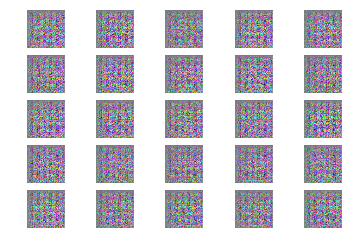

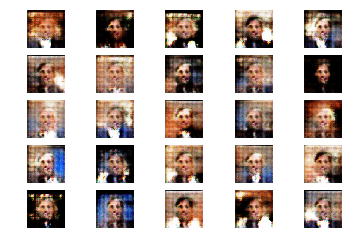

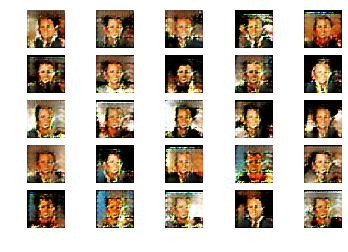

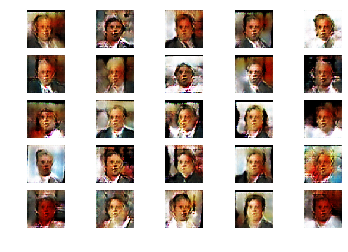

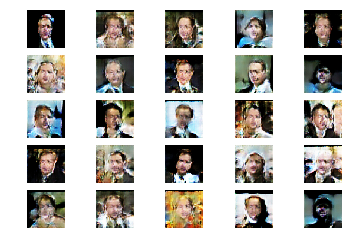

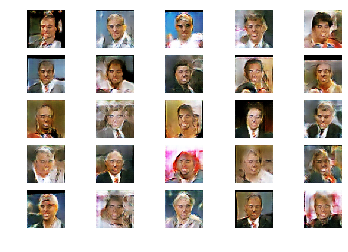

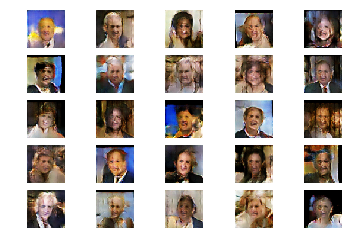

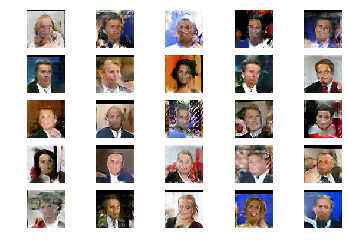

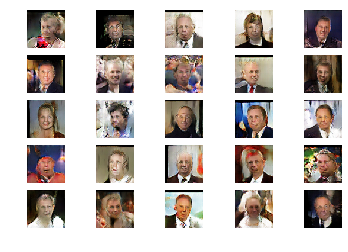

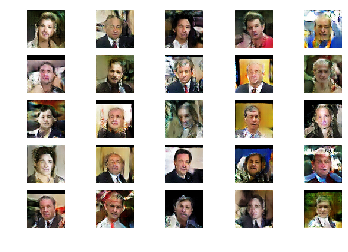

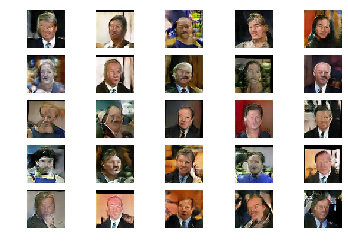

In [4]:
gan.train(epochs=10000, batch_size=128, sample_interval=1000)

In [5]:
gan.generator.save('./saved_model/dcgan2_generator.h5')
gan.discriminator.save('./saved_model/dcgan2_discriminator.h5')
gan.combined.save('./saved_model/dcgan2_combined.h5')

In [6]:
from keras.models import load_model
generator = load_model('./saved_model/dcgan2_generator.h5')

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
model = generator.layers[1]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 512)         13107712  
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 256)       3277056   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 256)       1024      
__________

conv2d_transpose_1


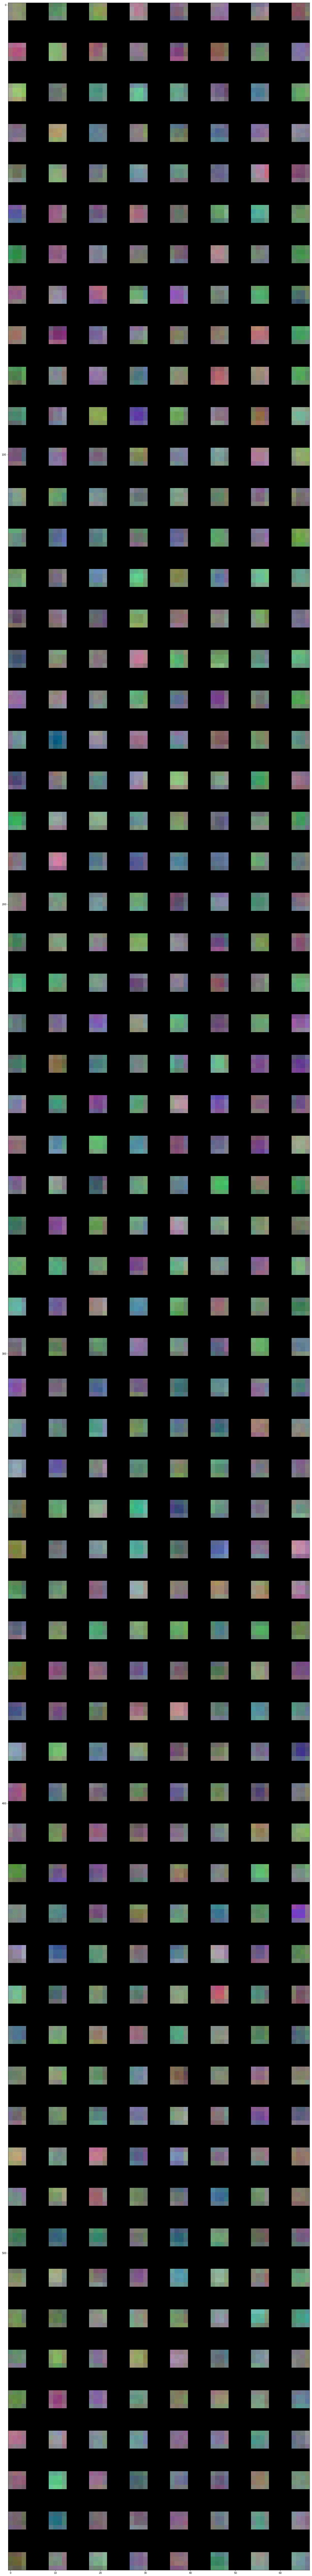

conv2d_transpose_2


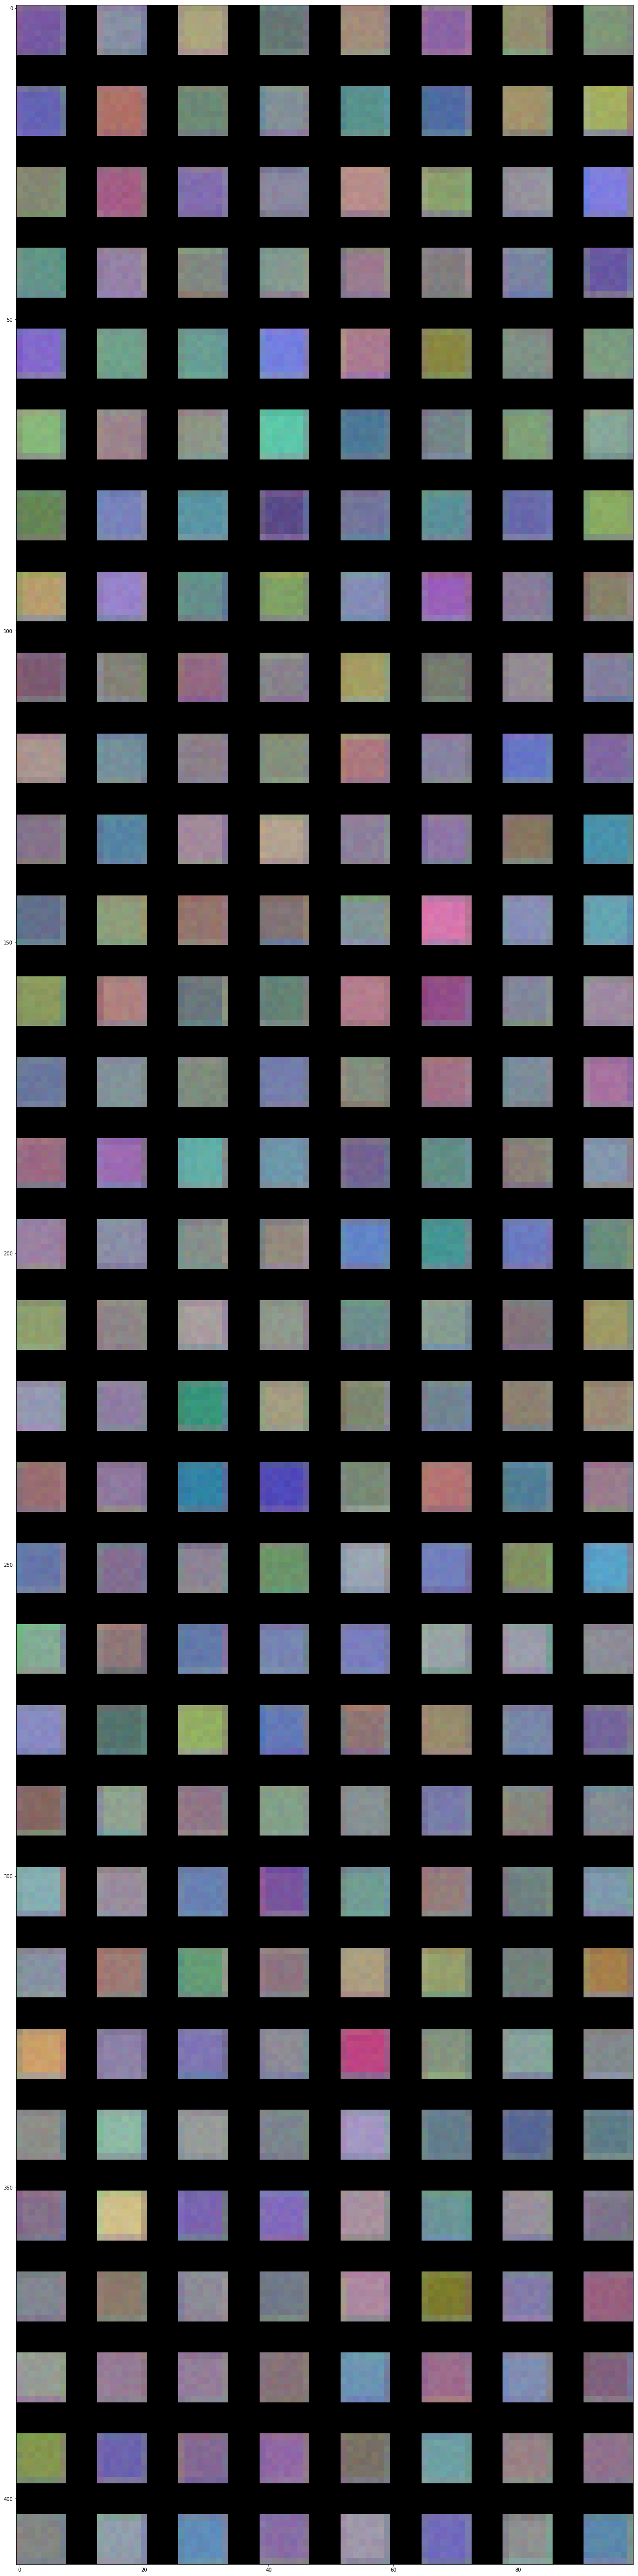

conv2d_transpose_3


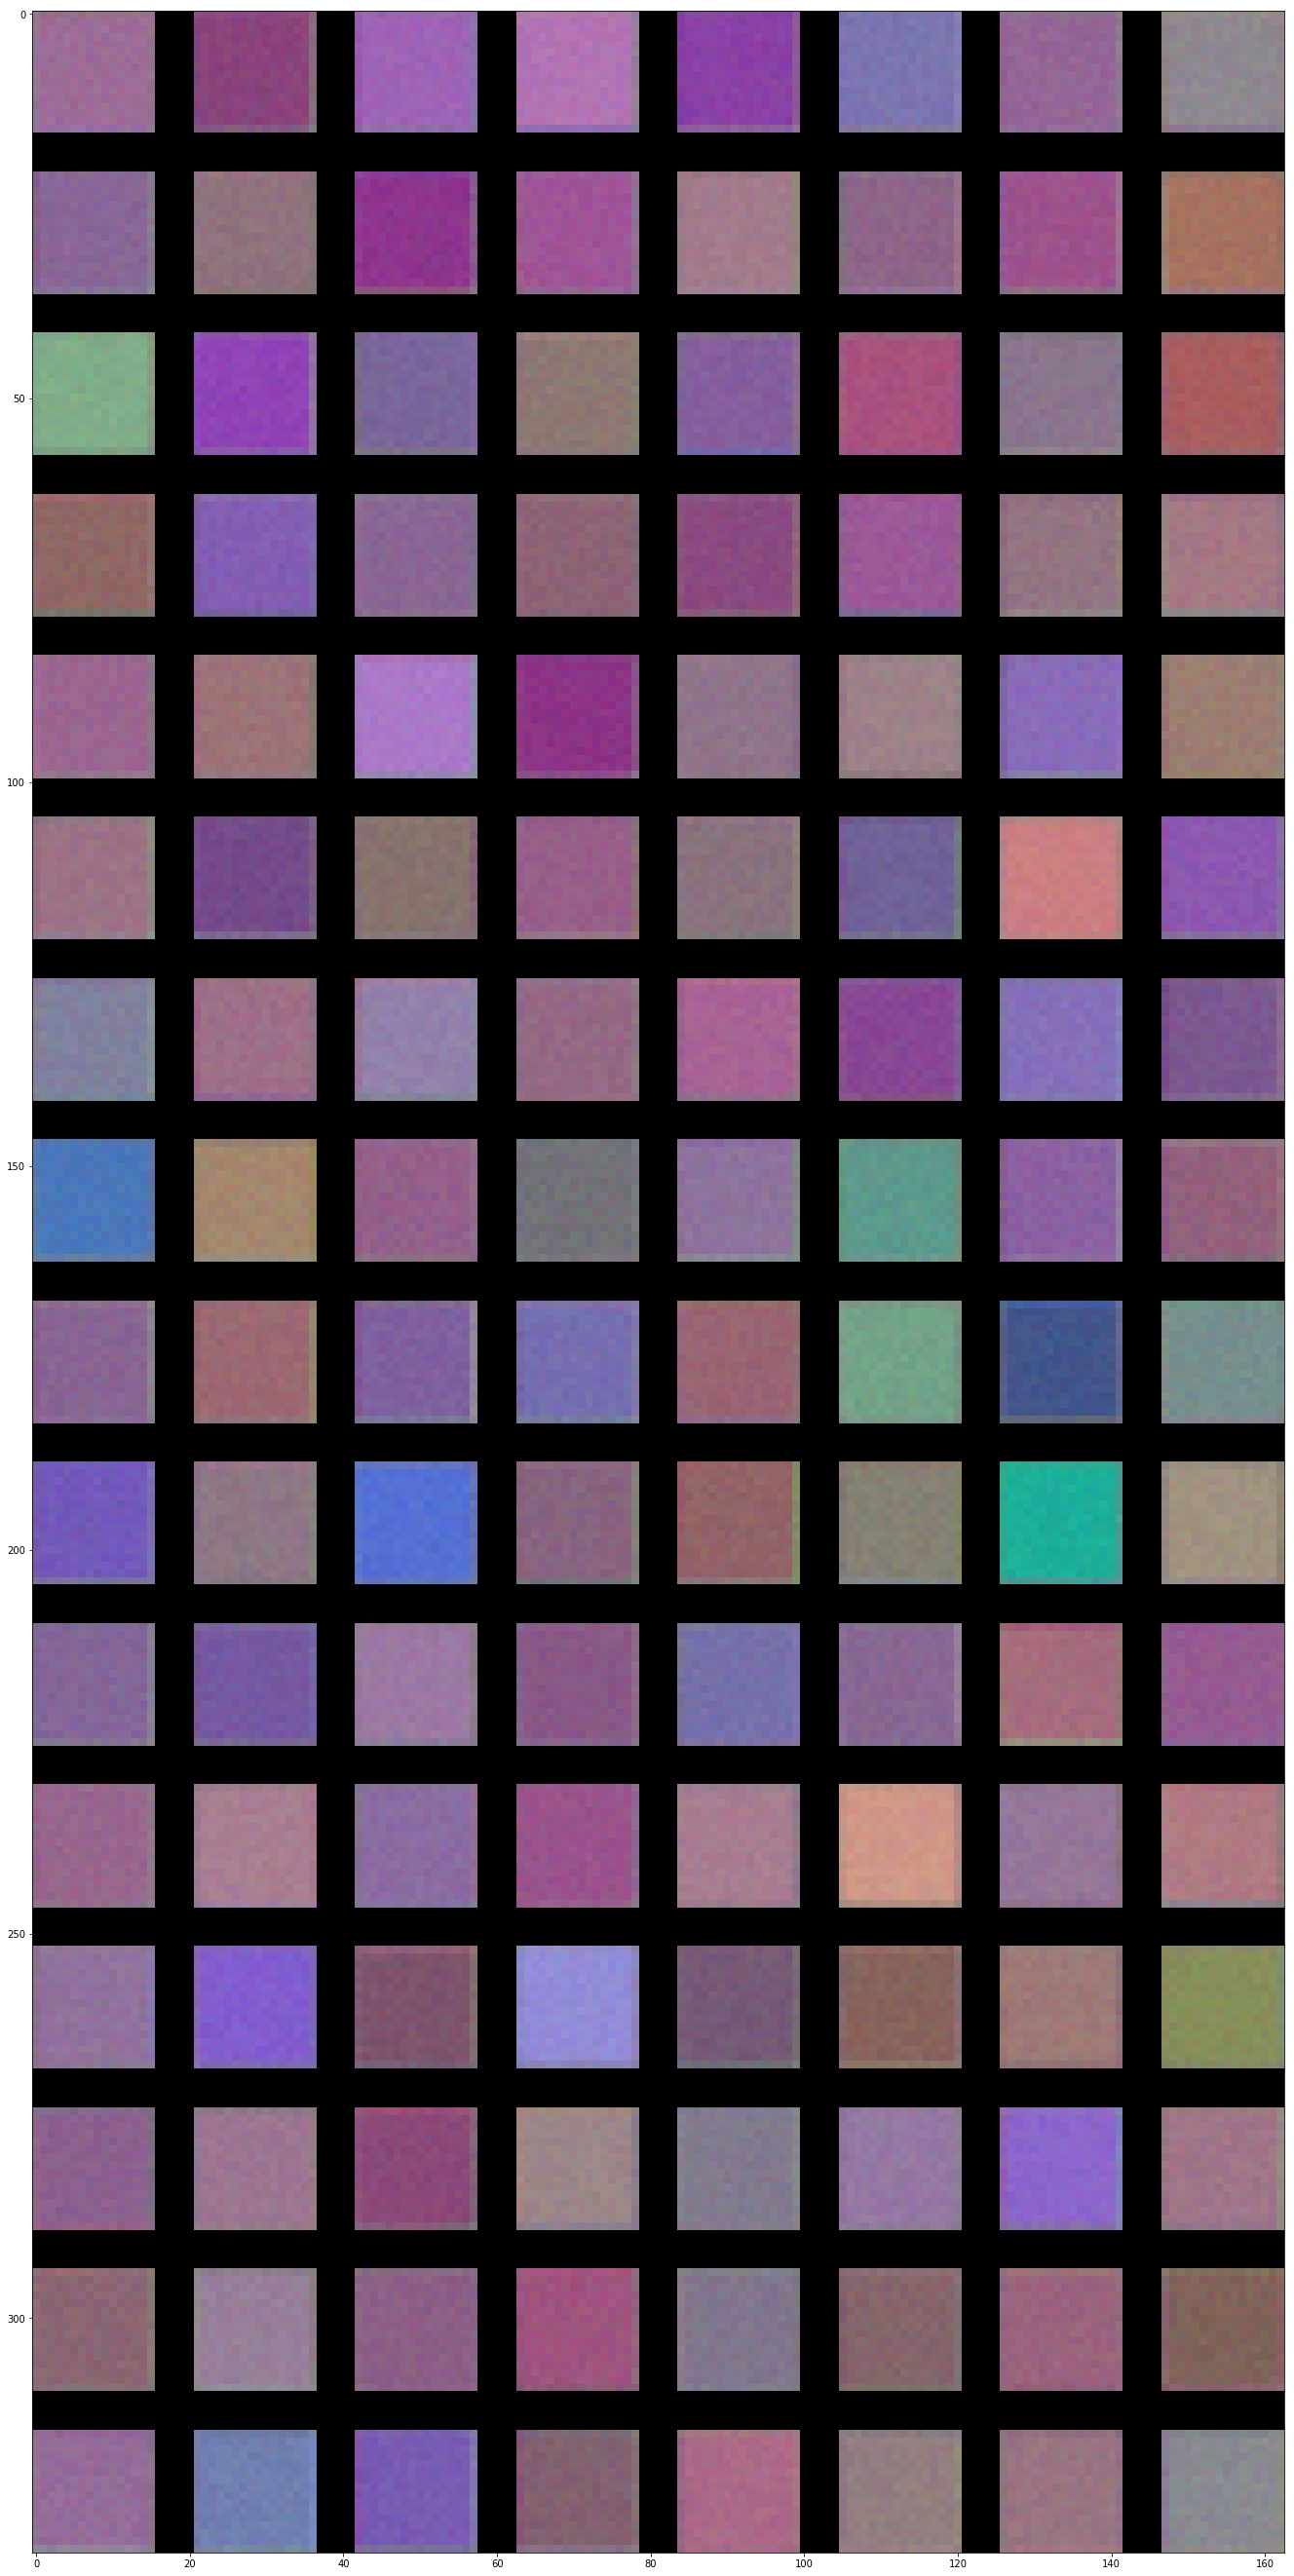

conv2d_transpose_4


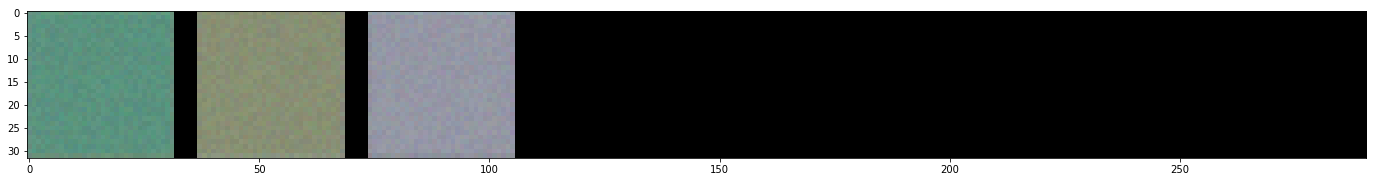

In [9]:
for layer in model.layers:
    if "conv2d" in layer.name:
        LayerVisualizer(model, layer.name)

conv2d_5


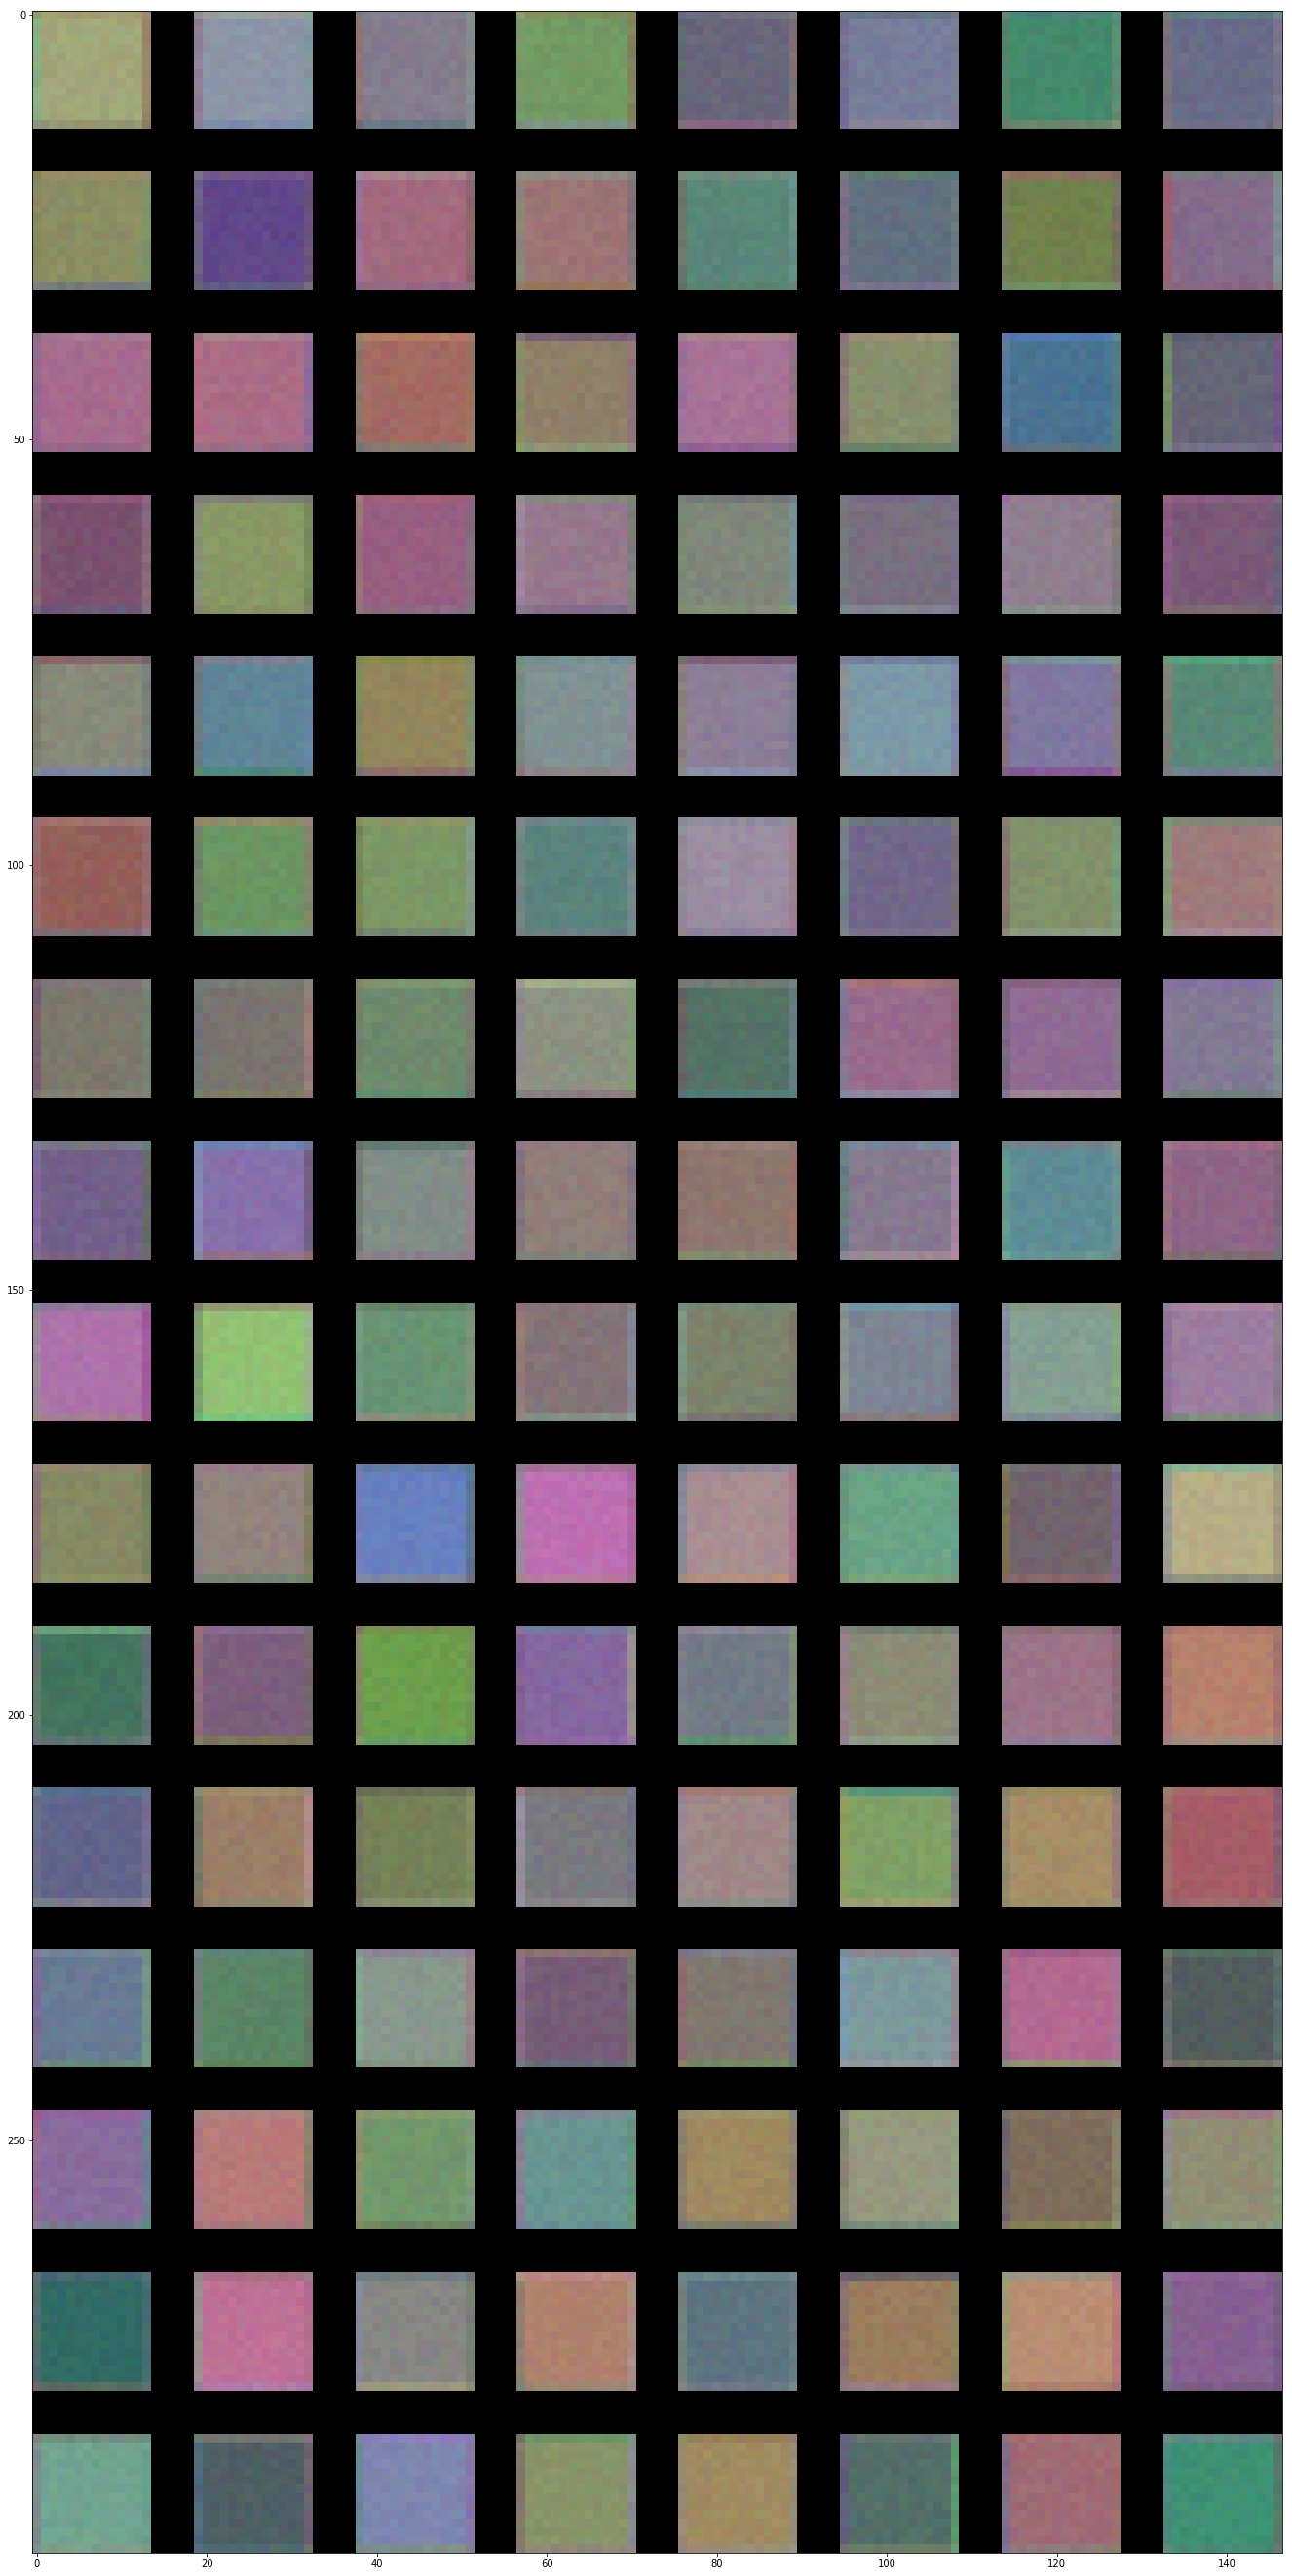

conv2d_6


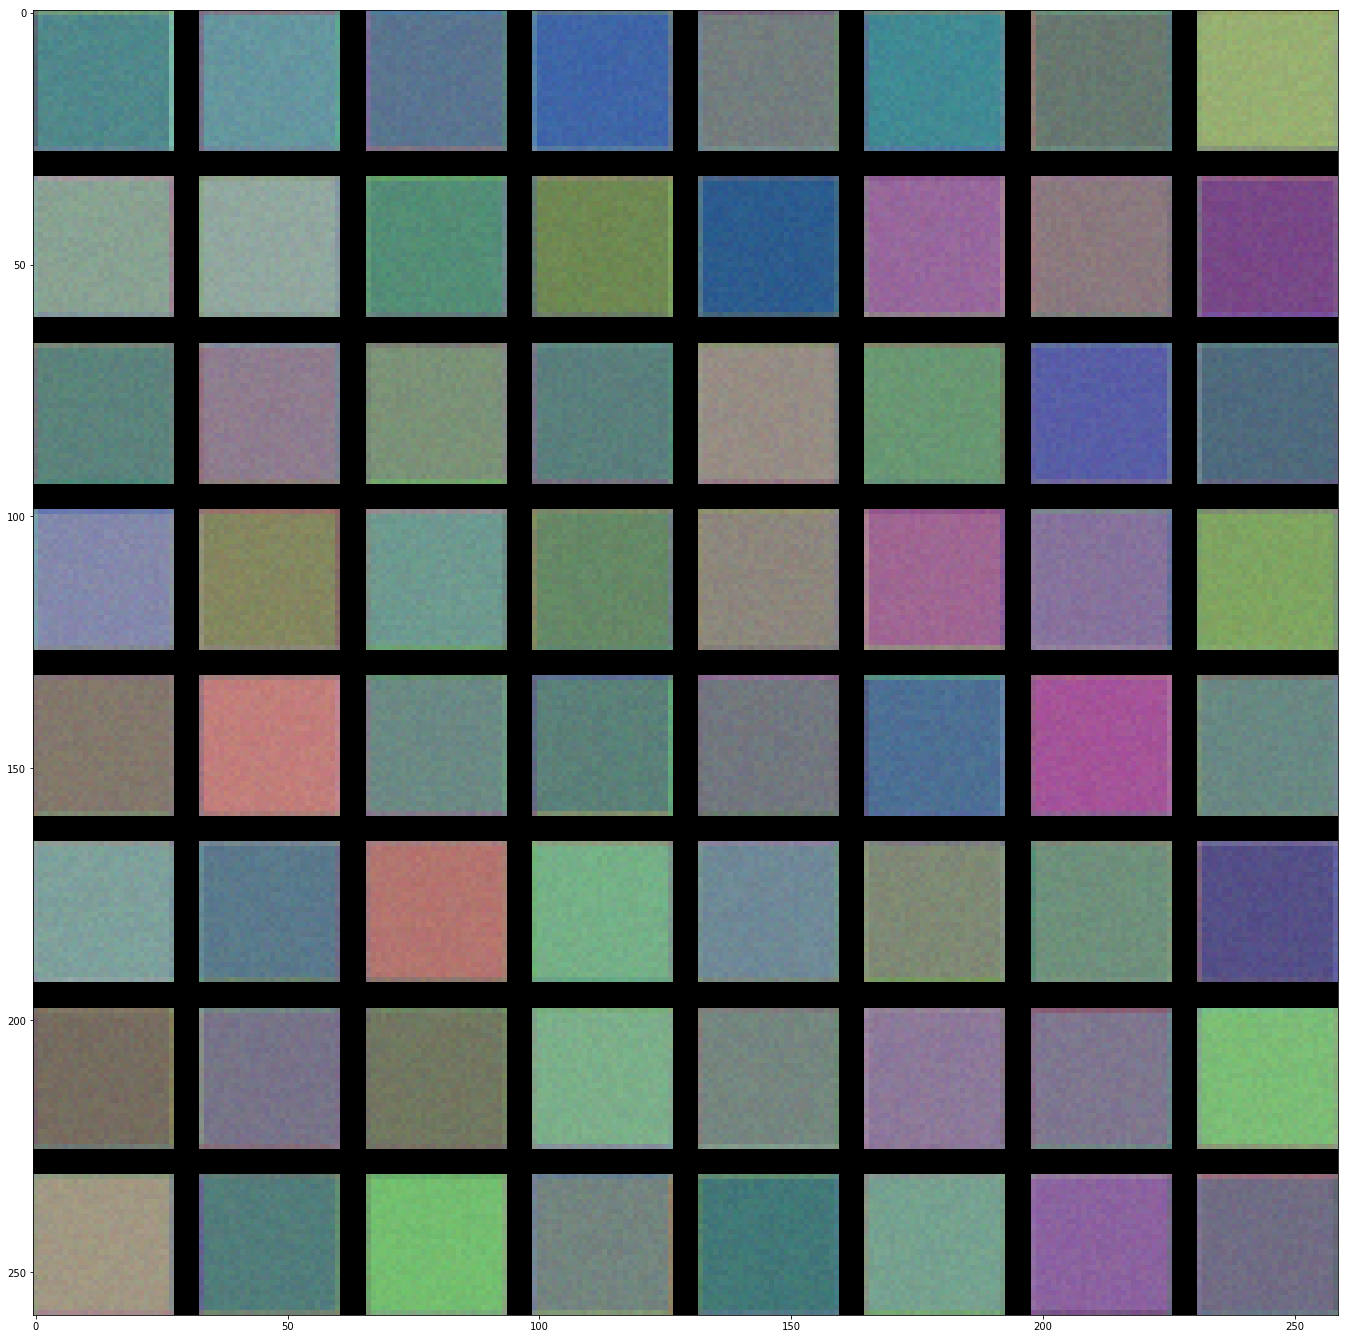

conv2d_7


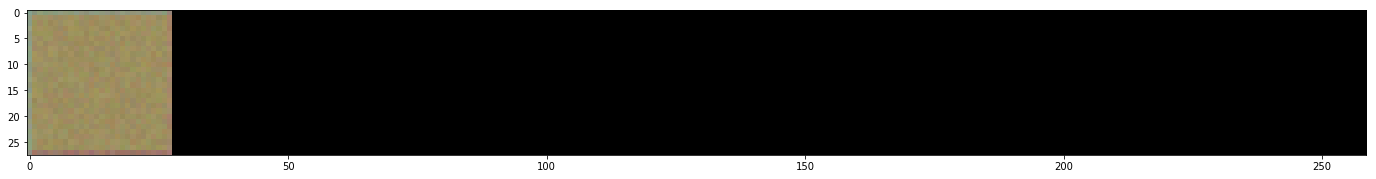

In [7]:
for layer_name in ["conv2d_5", "conv2d_6", "conv2d_7"]:
    LayerVisualizer(model, layer_name)

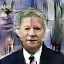

In [19]:
# (X_train, y_train), (_, _) = cifar100.load_data(label_mode='fine')
# X_train = X_train[y_train.flatten() == 8]
noise = np.random.normal(0, 1, (32, 100))
gen_imgs = gan.generator.predict(noise)
gen_imgs = (0.5 * gen_imgs[random.randint(0, 32)] + 0.5) * 255
gen_imgs = gen_imgs.astype('uint8')
img = Image.fromarray(gen_imgs)
img.save("dcgan.png")
img